In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

tfd = tf.contrib.distributions


def make_encoder(data, code_size):
    x = tf.layers.flatten(data)
    x = tf.layers.dense(x, 256, tf.nn.relu)
    x = tf.layers.dense(x, 256, tf.nn.relu)
    loc = tf.layers.dense(x, code_size)
    scale = tf.layers.dense(x, code_size, tf.nn.softplus)
    return tfd.MultivariateNormalDiag(loc, scale)


def make_prior(code_size):
    loc = tf.zeros(code_size)
    scale = tf.ones(code_size)
    return tfd.MultivariateNormalDiag(loc, scale)


def make_decoder(code, data_shape):
    x = code
    x = tf.layers.dense(x, 256, tf.nn.relu)
    x = tf.layers.dense(x, 256, tf.nn.relu)
    loc = tf.layers.dense(x, 28*28)
    scale = tf.ones(28*28)
    loc = tf.reshape(loc, [-1] + data_shape)
    scale = tf.reshape(scale, [-1] + data_shape)
    return tfd.Independent(tfd.MultivariateNormalDiag(loc, scale))


'''def plot_codes(ax, codes, labels):
    ax.scatter(codes[:, 0], codes[:, 1], s=2, c=labels, alpha=0.1)
    ax.set_aspect('equal')
    ax.set_xlim(codes.min() - .1, codes.max() + .1)
    ax.set_ylim(codes.min() - .1, codes.max() + .1)
    ax.tick_params(
        axis='both', which='both', left='off', bottom='off',
        labelleft='off', labelbottom='off')'''

def plot_codes(codes, labels):
    plt.scatter(codes[:,0], codes[:,1],s=2, c= labels, alpha=0.4)
    plt.colorbar()
    plt.show()

'''
def plot_samples(ax, samples):
    for index, sample in enumerate(samples):
        ax[index].imshow(sample, cmap='gray')
        ax[index].axis('off')
'''

def plot_samples(samples):
    fig, ax = plt.subplots(nrows=1, ncols=15, figsize=(30, 30))
    for index, sample in enumerate(samples):
        ax[index].imshow(sample, cmap='gray')
        ax[index].axis('off')
    plt.show()

def latent_fig(epoch):
    nx = ny = 20
    x_values = np.linspace(-3, 3, nx)
    y_values = np.linspace(-3, 3, ny)
    print("After Epoch ", epoch, " :")
    canvas = np.empty((28*ny, 28*nx))
    for i, yi in enumerate(x_values):
      for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*128)
        #x_mean = sess.run(latent_samples, feed_dict={noise: z_mu})
        x_mean = sess.run(latent_samples)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0]
    
    plt.figure(figsize=(8, 10))        
    Xi, Yi = np.meshgrid(x_values, y_values)
    plt.imshow(canvas, origin="upper", cmap="gray")
    plt.tight_layout()
    plt.show()


data = tf.placeholder(tf.float32, [None, 28, 28])

make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)

# Define the model.
prior = make_prior(code_size=2)
posterior = make_encoder(data, code_size=2)
code = posterior.sample()

# Define the loss.
likelihood = make_decoder(code, [28, 28]).log_prob(data)
divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)
optimize = tf.train.AdamOptimizer(0.001).minimize(-elbo)
init_op = tf.initialize_all_variables()

samples = make_decoder(prior.sample(15), [28, 28]).mean()

#noise = tf.placeholder(tf.float32, shape=[None, 2])
latent_samples = make_decoder(prior.sample(15), [28,28]).mean() 

mnist = input_data.read_data_sets('MNIST_data/')
#fig, ax = plt.subplots(nrows=4, ncols=11, figsize=(30, 30))

prev_elbo = 9999.0
elbo_list = list()
with tf.train.MonitoredSession() as sess:
    sess.run(init_op)
    for epoch in range(100):
        feed = {data: mnist.test.images.reshape([-1, 28, 28])}
        test_elbo, test_codes, test_samples = sess.run([elbo, code, samples], feed)
        test_elbo = test_elbo * (-1)
        elbo_list.append(test_elbo)
        print('Epoch', epoch, 'elbo', test_elbo)

        if(test_elbo >= prev_elbo and epoch > 50):
            print("Solution Converged")
            plot_codes(test_codes, mnist.test.labels)
            plot_samples(test_samples)
            latent_fig(epoch)
            break
        prev_elbo = test_elbo
        
        if epoch in [1,5,25,50]:
            plot_codes(test_codes, mnist.test.labels)
            plot_samples(test_samples)
            latent_fig(epoch)
        for _ in range(600):
            feed = {data: mnist.train.next_batch(128)[0].reshape([-1, 28, 28])}
            sess.run(optimize, feed)
#plt.savefig('vae-mnist.png', dpi=300, transparent=True, bbox_inches='tight')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch 0 elbo 765.4951782226562
Epoch 1 elbo 743.1491088867188
Epoch 2 elbo 742.2658081054688
Epoch 3 elbo 742.0343017578125
Epoch 4 elbo 741.7819213867188
Epoch 5 elbo 741.5501098632812
Epoch 6 elbo 741.2665405273438
Epoch 7 elbo 741.0477294921875
Epoch 8 elbo 740.9150390625
Epoch 9 elbo 740.8253173828125
Epoch 10 elbo 740.755859375
Epoch 11 elbo 740.6475830078125
Epoch 12 elbo 740.6616821289062
Epoch 13 elbo 740.6035766601562
Epoch 14 elbo 740.4744873046875
Epoch 15 elbo 740.5109252929688
Epoch 16 elbo 740.427978515625
Epoch 17 elbo 740.3729248046875
Epoch 18 elbo 740.3214111328125
Epoch 19 elbo 740.3184814453125
Epoch 20 elbo 740.34765625
Epoch 21 elbo 740.2587280273438
Epoch

Text(0.5, 0, 'Eploch')

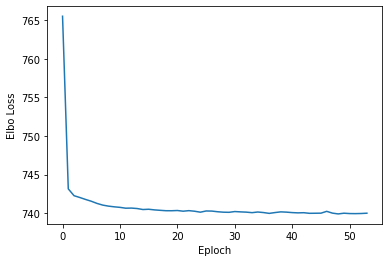

In [0]:
plt.plot(elbo_list)
plt.ylabel('Elbo Loss')
plt.xlabel('Eploch')